# Download the data
Before running the followiing cell, go to the Challenge page https://www.codabench.org/competitions/2626/ → Files and download the `Dataset.zip`. Once downloaded, unzip it, you should have a `Dataset` folder now with three different files inside.

Afterwards, load the data to this notebook by clicking 📁 sign on the left sidebar. Drag and drop the files there. It might take some time to upload the data to the notebook.

Now let's load the data and inspect the data, starting with the necessary inputs!


In [1]:
!pip install 'tensorflow[and-cuda]'

In [2]:
!rm -rf ~/.nv

In [3]:
# Let's start with necessary imports
import os
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from scipy.fft import rfft, rfftfreq

2025-01-12 10:18:24.078916: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736677104.100120    4794 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736677104.106646    4794 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-12 10:18:24.129838: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# load data and normalize it
background = np.load('../data/background.npz')['data']
peak_frequencies = np.zeros((100000, 2))
powers = np.zeros((100000, 2))

for i in range(background.shape[0]):
    for j in range(background.shape[1]):
        fft_vals = np.fft.fft(background[i, j])
        power_spectrum = np.abs(fft_vals)**2
        peak_frequencies[i, j] = np.argmax(power_spectrum)
        powers[i, j] = np.sum(power_spectrum)
peak_frequencies = peak_frequencies[..., np.newaxis]
powers = powers[..., np.newaxis]
background = np.concatenate([background, peak_frequencies, powers], axis=2)
stds = np.std(background, axis=-1)[:, :, np.newaxis]
background = background/stds
background = np.swapaxes(background, 1, 2)

bbh = np.load('../data/bbh_for_challenge.npy')
peak_frequencies = np.zeros((100000, 2))
powers = np.zeros((100000, 2))

for i in range(bbh.shape[0]):
    for j in range(bbh.shape[1]):
        fft_vals = np.fft.fft(bbh[i, j])
        power_spectrum = np.abs(fft_vals)**2
        peak_frequencies[i, j] = np.argmax(power_spectrum)
        powers[i, j] = np.sum(power_spectrum)
peak_frequencies = peak_frequencies[..., np.newaxis]
powers = powers[..., np.newaxis]
bbh = np.concatenate([bbh, peak_frequencies, powers], axis=2)
stds = np.std(bbh, axis=-1)[:, :, np.newaxis]
bbh = bbh/stds
bbh = np.swapaxes(bbh, 1, 2)

sglf = np.load('../data/sglf_for_challenge.npy')
peak_frequencies = np.zeros((100000, 2))
powers = np.zeros((100000, 2))

for i in range(sglf.shape[0]):
    for j in range(sglf.shape[1]):
        fft_vals = np.fft.fft(sglf[i, j])
        power_spectrum = np.abs(fft_vals)**2
        peak_frequencies[i, j] = np.argmax(power_spectrum)
        powers[i, j] = np.sum(power_spectrum)
peak_frequencies = peak_frequencies[..., np.newaxis]
powers = powers[..., np.newaxis]
sglf = np.concatenate([sglf, peak_frequencies, powers], axis=2)
stds = np.std(sglf, axis=-1)[:, :, np.newaxis]
sglf = sglf/stds
sglf = np.swapaxes(sglf, 1, 2)

In [5]:
# Create train and test datasets

x_train, x_test, y_train, y_test = train_test_split(
     background, background, test_size=0.2, random_state=42)

print(f'x train/test shapes: {x_train.shape} {x_test.shape}')
print(f'y train/test shapes: {y_train.shape} {y_test.shape}')

x train/test shapes: (80000, 202, 2) (20000, 202, 2)
y train/test shapes: (80000, 202, 2) (20000, 202, 2)


## Build the model

Our model processes a tensor of shape `(batch size, sequence length, features)`,
where `sequence length` is the number of time steps and `features` is each input
timeseries.

We include residual connections, layer normalization, and dropout.
The resulting layer can be stacked multiple times.

The projection layers are implemented through `keras.layers.Conv1D`.

The model includes the following components:

`Transformer Encoder`: Includes residual connections, layer normalization, dropout, and multi-head attention layers. The projection layers are implemented using `keras.layers.Conv1D`. These layers can be stacked multiple times.

`Dense Decoder`: After the transformer encoder, the dense decoder is used. It flattens the input, applies several dense layers with residual connections, dropout, and layer normalization, and then reshapes the output back to the original input shape.

The final layer of the model is a dense layer that outputs a tensor of the same shape as the input.


In [6]:
class Model:
    def __init__(self):
        super().__init__()

    def transformer_encoder(self, inputs, head_size, num_heads, ff_dim, dropout=0):
        x = layers.MultiHeadAttention(
            key_dim=head_size, num_heads=num_heads, dropout=dropout
        )(inputs, inputs)
        x = layers.Dropout(dropout)(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        res = x + inputs

        x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
        x = layers.Dropout(dropout)(x)
        x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        return x + res

    def dense_decoder(self, inputs, ff_dim, output_dim, dropout=0):
        # Flatten the input to apply dense layers
        x = layers.Flatten()(inputs)
        x = layers.Dense(ff_dim, activation="relu")(x)
        x = layers.Dropout(dropout)(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        res = layers.Dense(ff_dim)(x)  # Align dimensions for residual

        x = layers.Dense(ff_dim, activation="relu")(x)
        x = layers.Dropout(dropout)(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        x = x + res

        x = layers.Dense(ff_dim, activation="relu")(x)
        x = layers.Dropout(dropout)(x)
        x = layers.Dense(np.prod(inputs.shape[1:]))(x)  # Output dimension should match the flattened input dimension
        x = layers.LayerNormalization(epsilon=1e-6)(x)

        # Reshape back to original input shape
        x = layers.Reshape(inputs.shape[1:])(x)
        return x + inputs  # Adding input directly, assuming output_dim matches inputs shape[-1]

    def build_model(self, input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, num_dense_blocks, dropout=0, mlp_dropout=0):
        inputs = keras.Input(shape=input_shape)

        # Encoder
        x = inputs
        for _ in range(num_transformer_blocks):
            x = self.transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

        encoder_output = x

        # Decoder
        x = encoder_output
        for _ in range(num_dense_blocks):
            x = self.dense_decoder(x, ff_dim, input_shape[-1], dropout)

        # Output layer
        outputs = layers.Dense(input_shape[-1])(x)

        self.ae = keras.Model(inputs, outputs)
        self.ae.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=1e-4))

    def predict(self, X, batch_size=32):
        return np.mean((self.ae.predict(X, batch_size=batch_size) - X) ** 2, axis=(1,2))

    def __call__(self, inputs, batch_size=64):
        return self.ae.predict(inputs, batch_size=batch_size)

    def save(self, path):
        self.ae.save(os.path.join(os.path.dirname(__file__), 'model.keras'))

    def load(self):
        self.ae = keras.models.load_model(os.path.join(os.path.dirname(__file__), 'model.keras'))

    def fit(self, x_train, **kwargs):
        history = self.ae.fit(x_train, x_train, **kwargs)
        return history

# Example usage:
input_shape = x_train.shape[1:]
head_size = 64
num_heads = 2
ff_dim = 64
num_transformer_blocks = 2
num_dense_blocks = 1
dropout = 0.1

# build the model
autoencoder = Model()
autoencoder.build_model(
    input_shape=input_shape,
    head_size=head_size,
    num_heads=num_heads,
    ff_dim=ff_dim,
    num_transformer_blocks=num_transformer_blocks,
    num_dense_blocks=num_dense_blocks,
    dropout=dropout
)

# Assuming x_train is your input data
history = autoencoder.fit(
    x_train, # For autoencoders, input is same as output
    validation_split=0.2,
    epochs=80,
    batch_size=32,
    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)


I0000 00:00:1736677117.545995    4794 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20732 MB memory:  -> device: 0, name: NVIDIA A10, pci bus id: 0000:81:00.0, compute capability: 8.6


Epoch 1/80


I0000 00:00:1736677125.367946    4846 service.cc:148] XLA service 0x7ff64402e360 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736677125.367984    4846 service.cc:156]   StreamExecutor device (0): NVIDIA A10, Compute Capability 8.6
2025-01-12 10:18:45.525190: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1736677126.218617    4846 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-12 10:18:47.040326: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
2025-01-12 10:18:48.879561: I e

  36/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 2.0222   

I0000 00:00:1736677157.264388    4846 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1994/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3742

2025-01-12 10:19:28.341437: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_17', 684 bytes spill stores, 528 bytes spill loads

2025-01-12 10:19:29.060001: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_17', 920 bytes spill stores, 732 bytes spill loads

2025-01-12 10:19:29.332900: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_17', 72 bytes spill stores, 72 bytes spill loads

2025-01-12 10:19:30.563064: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_17', 12 bytes spill stores, 12 bytes spill loads



2000/2000 ━━━━━━━━━━━━━━━━━━━━ 54s 8ms/step - loss: 0.3734 - val_loss: 3.9267e-05
Epoch 2/80
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - loss: 0.0072 - val_loss: 1.8132e-05
Epoch 3/80
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0021 - val_loss: 3.4517e-05
Epoch 4/80
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0023 - val_loss: 6.3657e-06
Epoch 5/80
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 3.8174e-04 - val_loss: 7.9449e-06
Epoch 6/80
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 8.1178e-04 - val_loss: 1.0969e-05
Epoch 7/80
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 5.2101e-04 - val_loss: 6.7472e-06
Epoch 8/80
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 1.3929e-04 - val_loss: 7.6544e-06
Epoch 9/80
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 1.1388e-04 - val_loss: 6.0854e-06
Epoch 10/80
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 4.9786e-05 - val_loss: 6.0959e-06
Epoch 11/80
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step 

In [7]:
# Save the entire model as a SavedModel.
__file__=''
!mkdir -p saved_model
autoencoder.save('')

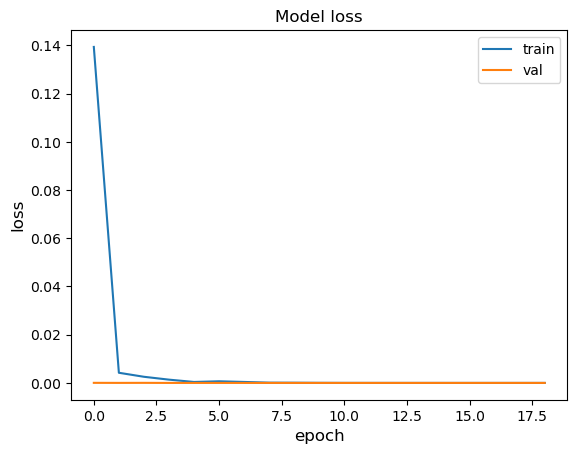

In [8]:
# This is just an example; you would probably like to train the model for more epochs
metric = "loss"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("Model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


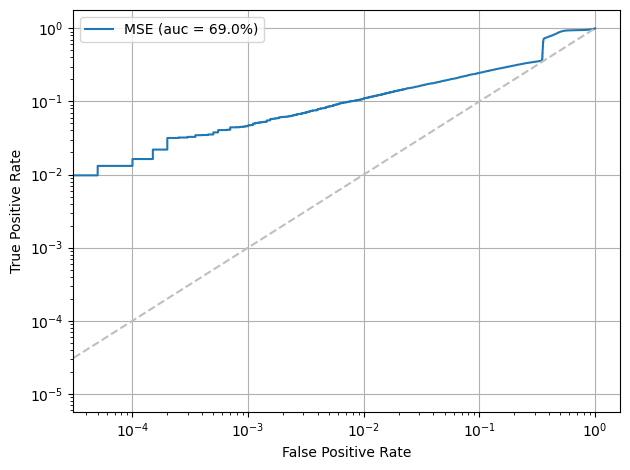

In [9]:
def make_plot_roc_curves(qcd, bsm):

    true_val = np.concatenate((np.ones(bsm.shape[0]), np.zeros(qcd.shape[0])))
    pred_val = np.concatenate((bsm, qcd))

    fpr_loss, tpr_loss, threshold_loss = roc_curve(true_val, pred_val)

    auc_loss = auc(fpr_loss, tpr_loss)


    qcd[::-1].sort()

    plt.plot(fpr_loss, tpr_loss, '-', label=f'MSE (auc = %.1f%%)'%(auc_loss*100.),
        linewidth=1.5)
    plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')

    plt.semilogx()
    plt.semilogy()
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# evaluate on test background and signal samples
background_test = autoencoder.predict(x_test)
signal_test = autoencoder.predict(bbh)

make_plot_roc_curves(background_test, signal_test)

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


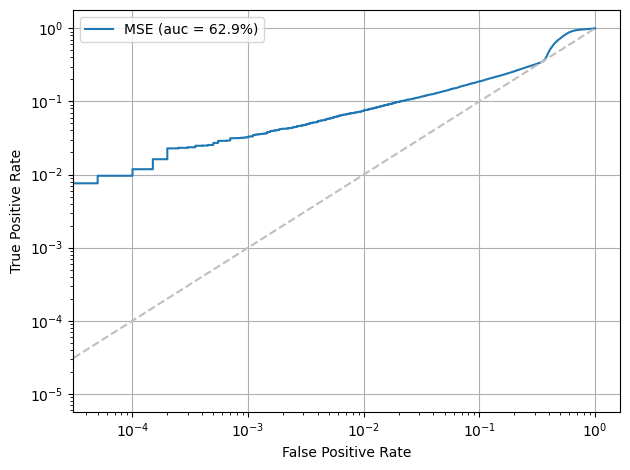

In [10]:
sglf_test = autoencoder.predict(sglf)
make_plot_roc_curves(background_test, sglf_test)

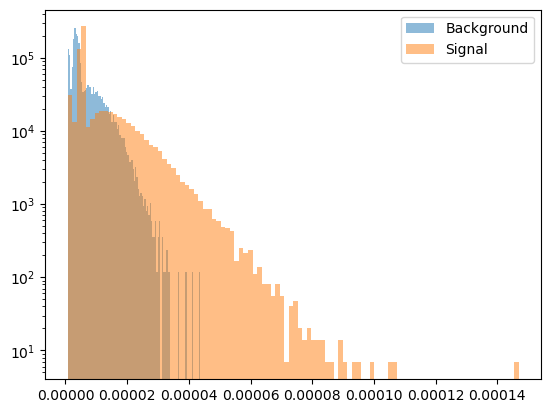

In [11]:
plt.hist(background_test, density=True, bins=100, alpha=0.5, label='Background')
plt.hist(signal_test, density=True, bins=100, alpha=0.5, label='Signal')
plt.semilogy()
plt.legend()

In [12]:
pretrained_model = Model()
pretrained_model.load()

# Check its architecture
pretrained_model.ae.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 202, 2)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 202, 2)    │      1,410 │ input_layer[0][0… │
│ (MultiHeadAttentio… │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 202, 2)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 202, 2)    │          4 │ dropout_1[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 202, 2)    │          0 │ layer_normalizat… │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 202, 64)   │        192 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 202, 64)   │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 202, 2)    │        130 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 202, 2)    │          4 │ conv1d_1[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 202, 2)    │          0 │ layer_normalizat… │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 202, 2)    │      1,410 │ add_1[0][0],      │
│ (MultiHeadAttentio… │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 202, 2)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 202, 2)    │          4 │ dropout_4[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 202, 2)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 202, 64)   │        192 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 202, 64)   │          0 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 202, 2)    │        130 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 202, 2)    │          4 │ conv1d_3[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 202, 2)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 207,632 (811.07 KB)

 Trainable params: 69,210 (270.35 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 138,422 (540.71 KB)